In [8]:
import re

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# Data source: https://www.kaggle.com/c/titanic/data
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

In [3]:
df_train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [4]:
df_test.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


## Define Data Types

Target:
* Survived

Categorical:
* Pclass: Though it is an ordinal variable, I will treat it as categorical, because there is only 3 levels, and the dependency is probably non-liner
* Sex
* Embarked

Numerical:
* Age
* SibSp
* Parch
* Fare

Text:
* Name: Some features can be created from it
* Cabin: Some features can be created from it

Unused:
* PassengerId: Obviously ID's are not useful for classification
* Ticket: For the first sight I don't see any useful info in it

In [7]:
label_name = "Survived"

categorical_feature_names = ["Pclass", "Sex", "Embarked"]
numerical_feature_names = ["Age", "SibSp", "Parch", "Fare"]
text_feature_names = ["Name", "Cabin"]

## Missing Values

Ratio of missing values of columns:
PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64


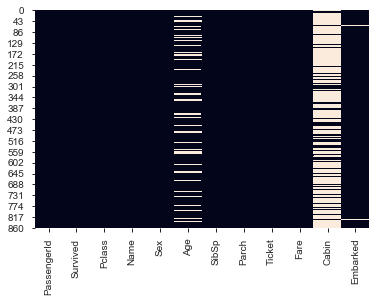

Ratio of missing values of columns:
PassengerId    0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.205742
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.002392
Cabin          0.782297
Embarked       0.000000
dtype: float64


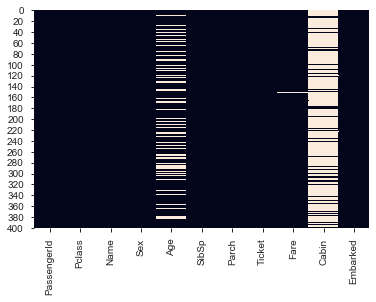

In [9]:
def inspect_missing(df):
    dataset_size = df.shape[0]
    print("Ratio of missing values of columns:")
    print(df.isnull().sum() / dataset_size)
    sns.heatmap(df.isnull(), cbar=False)
    plt.show()

inspect_missing(df_train)

inspect_missing(df_test)

* Age has a considerable amount of missing values (20% in training set)
* Cabin has a lot of missing values (77% in training set)
* Embarked has a small amount of missing values (0.22%) in training set
* Fare has a small amount of missing values (0.24%) in test set
* The distribution of missing values is even

We can add new features to signal if cabin or age is missing, maybe this is correlating with the target variable

In [11]:
df_train["Cabin_missing"] = df_train["Cabin"].isna()
df_train["Age_missing"] = df_train["Age"].isna()

categorical_feature_names += ["Cabin_missing", "Age_missing"]

# Exploratory Data Analysis / Feature Engineering

## Women and children first

For the next section it worths understanding the quote "Women and children first".

The phrase was popularised by its usage on the RMS Titanic. The Second Officer suggested to Captain Smith, "Hadn't we better get the women and children into the boats, sir?", to which the captain responded: "put the women and children in and lower away". The First (Officer Murdoch) and Second (Officer Lightoller) officers interpreted the evacuation order differently; Murdoch took it to mean women and children first, while Lightoller took it to mean women and children only. Second Officer Lightoller lowered lifeboats with empty seats if there were no women and children waiting to board, while First Officer Murdoch allowed a limited number of men to board if all the nearby women and children had embarked.

Source: [Wikipedia](https://en.wikipedia.org/wiki/Women_and_children_first)

## Helper Functions

In [17]:
def explore_binary(series):
    print("Ratio: {}".format(series.mean()))

def dependency_categorical(feature, label):
    """ Makes a crosstabulation between categorical feature and label """
    df_crosstab = pd.crosstab(feature, label)
    counts = df_crosstab.sum(axis=1)
    df_crosstab = df_crosstab.divide(counts, axis=0)
    df_crosstab["Count"] = counts
    df_crosstab = df_crosstab.sort_values("Count", ascending=False)
    print(df_crosstab)

## Label

In [18]:
print("Survived")
explore_binary(df_train[label_name])

Survived
Ratio: 0.3838383838383838


There is no huge imbalance in the labels.

## Pclass

In [14]:
dependency_categorical(df_train["Pclass"], df_train[label_name])

Survived         0         1  Count
Pclass                             
3         0.757637  0.242363    491
1         0.370370  0.629630    216
2         0.527174  0.472826    184


* The third class tickets are in majority
* The higher the class number, the lower the survival ratio, as expected

## Sex

In [19]:
dependency_categorical(df_train["Sex"], df_train[label_name])

Survived         0         1  Count
Sex                                
male      0.811092  0.188908    577
female    0.257962  0.742038    314


* The majority of pessengers are males
* The survival ratio of females (74%) is significantly higher than of males (19%)

## Embarked

In [20]:
dependency_categorical(df_train["Embarked"], df_train[label_name])

Survived         0         1  Count
Embarked                           
S         0.663043  0.336957    644
C         0.446429  0.553571    168
Q         0.610390  0.389610     77


Passengers were boarding the Titanic from 3 different cities in Europe, before heading off to New York: Southampton (England) encoded as `S`, Cherbourg (France) encoded as `C` and Queenstown (Ireland) encoded as `Q`.

* Most of the passengers embarked in Southampton
* The port of embarkation explains some variance
    * Does the port really matter?
    * Does this feature only correlate to other features, that cause this effect?
    * Does the port contain some information that can't be explained by the other features?
    * We will have to answer these questions later

## Age

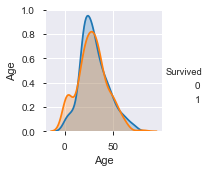

In [31]:
pairplot_variables = ["Age"]
df_train_pairplot = df_train[pairplot_variables + ["Survived"]].dropna()
sns.pairplot(df_train_pairplot, vars=pairplot_variables, hue="Survived")

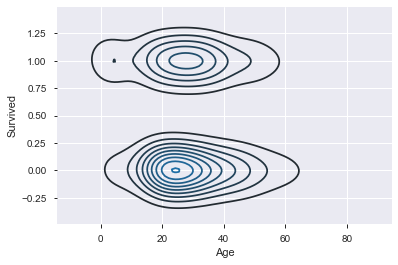

In [33]:
sns.kdeplot(df_train_pairplot["Age"], data2=df_train_pairplot["Survived"])

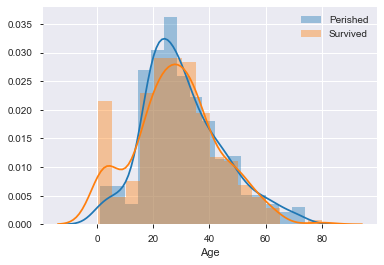

In [46]:
sns.distplot(df_train_pairplot[df_train_pairplot["Survived"] == 0]["Age"], kde=True, norm_hist=True, label="Perished")
sns.distplot(df_train_pairplot[df_train_pairplot["Survived"] == 1]["Age"], kde=True, norm_hist=True, label="Survived")
plt.legend()